# NEOs in the sky

... please jump to cell #23, to continue with the next tutorial.

In [1]:
# Standard libraries
import datetime
import math
import pathlib
import sqlite3
import sys

# Installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import spiceypy

# Append to root directory of this repository
sys.path.append("../")

# Auxiliary module that contains the apparent magnitude
from auxiliary import photometry

In [2]:
# Accessing the NEO database
database_dir = pathlib.Path("../databases/neos/")
database_file = pathlib.Path("neodys.db")
database_filepath = database_dir / database_file

# Establish a connection to the database and set a cursor
neodys_db_con = sqlite3.connect(database_filepath)
neodys_db_cur = neodys_db_con.cursor()

In [3]:
# Get all information from the DB. Since the DB is rather small, this won't cause any issues!
neo_df = pd.read_sql("SELECT * FROM main", neodys_db_con)

# Close the database.
neodys_db_con.close()

In [4]:
neo_df

,Name,Epoch_MJD,SemMajAxis_AU,Ecc_,Incl_deg,LongAscNode_deg,ArgP_deg,MeanAnom_deg,AbsMag_,SlopeParamG_,Aphel_AU,Perihel_AU,NEOClass
0,433,59600.0,1.458273,0.222727,10.828461,304.296346,178.897177,246.904119,10.87,0.46,1.783070,1.133476,Amor
1,719,59600.0,2.637505,0.546959,11.575272,183.855259,156.227573,278.197185,15.53,0.15,4.080112,1.194899,Amor
2,887,59600.0,2.473158,0.570486,9.394141,110.428769,350.493276,86.607207,13.33,-0.12,3.884060,1.062256,Amor
3,1036,59600.0,2.665849,0.533122,26.677908,215.517191,132.428118,140.654843,9.41,0.30,4.087071,1.244627,Amor
4,1221,59600.0,1.918731,0.435843,11.883264,171.320251,26.643922,261.044505,17.40,0.15,2.754996,1.082467,Amor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29044,2022KY2,59600.0,1.439076,0.290852,9.562666,220.831102,344.748373,308.992894,24.82,0.15,1.857634,1.020519,Amor
29045,2022KZ,59600.0,1.404505,0.389038,10.755270,64.554335,243.245936,257.305079,26.44,0.15,1.950911,0.858099,Apollo
29046,2022KZ1,59600.0,1.643745,0.562916,31.322592,63.673736,262.310279,276.670518,26.14,0.15,2.569035,0.718455,Apollo
29047,2022KZ2,59600.0,1.342108,0.412424,13.556790,237.807367,283.141272,319.777066,26.25,0.15,1.895626,0.788590,Apollo


In [5]:
# Load SPICE kernels
spiceypy.furnsh("../kernels/spk/de432s.bsp")
spiceypy.furnsh("../kernels/lsk/naif0012.tls")
spiceypy.furnsh("../kernels/pck/gm_de431.tpc")

# Get the G*M value of the Sun
_, gm_sun_pre = spiceypy.bodvcd(bodyid=10, item='GM', maxn=1)
gm_sun = gm_sun_pre[0]

In [6]:
# Determine today's datetime
curr_time_utc = datetime.datetime.now().strftime("%Y-%m-%d")
curr_time_et = spiceypy.utc2et(curr_time_utc)

In [7]:
sun2earth_position_vec = spiceypy.spkgps(targ=399,
                                     et=curr_time_et,
                                     ref="ECLIPJ2000",
                                     obs=10)[0]
sun2earth_position_vec

array([ 1.00572855e+08,  1.08803008e+08, -6.31294441e+03])

In [8]:
# For our computations we need to convert some values from AU to km and from deg to rad
neo_df.loc[:, "Perihel_km"] = neo_df["Perihel_AU"].apply(lambda x: spiceypy.convrt(x, "AU", "km"))
neo_df.loc[:, "Incl_rad"] = neo_df["Incl_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "LongAscNode_rad"] = neo_df["LongAscNode_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "ArgP_rad"] = neo_df["ArgP_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "MeanAnom_rad"] = neo_df["MeanAnom_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "Epoch_JD"] = neo_df["Epoch_MJD"].apply(lambda x: x + 2400000.5)
neo_df.loc[:, "Epoch_et"] = neo_df["Epoch_JD"].apply(lambda x: spiceypy.utc2et(str(x) + " JD"))

In [9]:
# Compute the position vector of each NEO as seen from the Sun
neo_df.loc[:, "sun2neo_position_vec"] = \
    neo_df.apply(lambda x: spiceypy.conics(elts=[x["Perihel_km"],
                                                 x["Ecc_"],
                                                 x["Incl_rad"],
                                                 x["LongAscNode_rad"],
                                                 x["ArgP_rad"],
                                                 x["MeanAnom_rad"],
                                                 x["Epoch_et"],
                                                 gm_sun],
                                         et=curr_time_et)[:3],
                 axis=1)

In [10]:
# Let's take the position value of (433) Eros and compare it with NASA Horizons
neo_df.iloc[0]["sun2neo_position_vec"]

array([-1.83788405e+08, -5.65561929e+07, -3.51375750e+07])

In [11]:
# To compute the apparent magnitude we need to re-compute the positional vectors and convert it to
# AU
neo_df.loc[:, "neo2earth_position_vec"] = \
    neo_df["sun2neo_position_vec"].apply(lambda x: sun2earth_position_vec - x)
neo_df.loc[:, "neo2sun_position_vec"] = \
    neo_df["sun2neo_position_vec"].apply(lambda x: -1.0 * x)

neo_df.loc[:, "neo2earth_position_vec_AU"] = \
    neo_df["neo2earth_position_vec"].apply(lambda x: [spiceypy.convrt(k, "km", "AU") for k in x])
neo_df.loc[:, "neo2sun_position_vec_AU"] = \
    neo_df["neo2sun_position_vec"].apply(lambda x: [spiceypy.convrt(k, "km", "AU") for k in x])

In [12]:
# Compute the apparent magnitude of each NEO for today!
neo_df.loc[:, "app_mag"] = \
    neo_df.apply(lambda x: photometry.hg_app_mag(abs_mag=x["AbsMag_"],
                                                 vec_obj2obs=x["neo2earth_position_vec_AU"],
                                                 vec_obj2ill=x["neo2sun_position_vec_AU"],
                                                 slope_g=x["SlopeParamG_"]), axis=1)

In [13]:
# Let's take a look. We can use e.g., Stellarium to get a "round about" feeling whether the
# app. mag. of Eros is correct
neo_df[["Name", "app_mag"]]

,Name,app_mag
0,433,13.683570
1,719,18.963399
2,887,20.411583
3,1036,16.303394
4,1221,19.661014
...,...,...
29044,2022KY2,28.291938
29045,2022KZ,27.246509
29046,2022KZ1,28.647700
29047,2022KZ2,30.355691


In [14]:
# Anyway ... we see that some app. mag. values appear to be outliers! The AbsMag_ does not appear
# to be realisitc (a simple placeholder?)
# https://newton.spacedys.com/neodys/index.php?pc=1.0
neo_df[["Name", "AbsMag_", "app_mag"]].sort_values(by="app_mag")

,Name,AbsMag_,app_mag
7444,2010LF64,-9.99,-7.701373
7437,2010LB67,0.17,3.898545
0,433,10.87,13.683570
347,85713,15.64,14.132386
933,217628,16.62,14.943498
...,...,...,...
23574,2020RD4,29.83,43.438107
12658,2015JN1,21.15,45.746163
28788,2022GX2,29.34,46.064462
7504,2010OJ129,99.90,101.324899


In [15]:
# We set some NEOs we'd like to remove
neos_2_del = ["2010LF64", "2010LB67", "2010OJ129", "2010HA71"]
neo_df = neo_df.loc[~neo_df["Name"].isin(neos_2_del)].copy()
neo_df.reset_index(drop=True, inplace=True)

Text(24.5, 3800, 'Pan-STARRS Lim. Mag.')

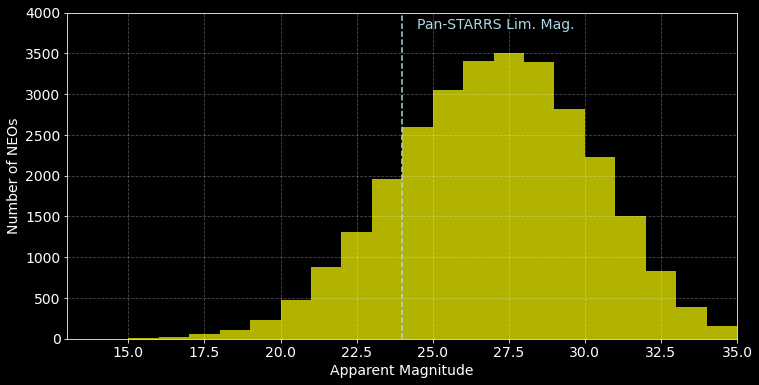

In [16]:
# Now let's plot the distribution of the app. mag.
# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(12, 6))
counts, bins, _ = plt.hist(neo_df["app_mag"],
                           bins=np.arange(13.0, 36.0, 1.0),
                           color="yellow",
                           alpha=0.7)

plt.grid(linestyle="dashed", alpha=0.3)
plt.xlim(13, 35)
plt.xlabel("Apparent Magnitude")
plt.ylabel("Number of NEOs")
plt.ylim(0, 4000)

# Add the limiting magnitude of Pan-STARSS as a vertical line
# https://panstarrs.ifa.hawaii.edu/pswww/?page_id=34
plt.vlines(24, 0, 4000, linestyles="dashed", color="lightblue")
plt.text(24.5, 3800, "Pan-STARRS Lim. Mag.", color="lightblue")

In [17]:
print(f"Number of NEOs Pan-STARRS could observe today: {int(sum(counts[:11]))}")
print(f"Number of NEOs Pan-STARRS could NOT observe today: {int(sum(counts[11:]))}")

Number of NEOs Pan-STARRS could observe today: 5056
Number of NEOs Pan-STARRS could NOT observe today: 23908


# Let's continue

In this session we will take a look how we can plot the NEOs in a sky plot and if there are certain "regions of interest".

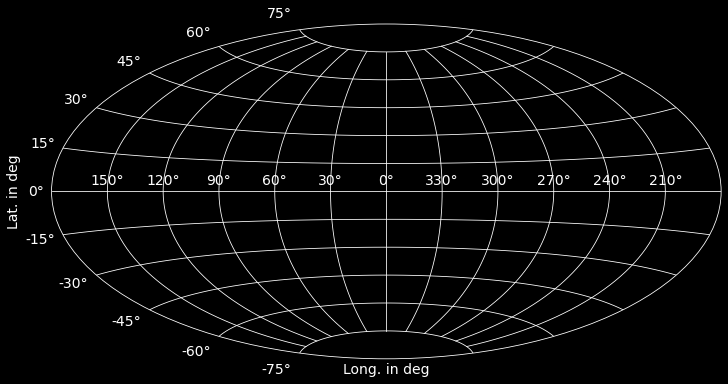

In [18]:
# First a small reminder from session #8: https://www.youtube.com/watch?v=6GnzgzePYLg

# Use a dark background
plt.style.use('dark_background')

# Set a figure
plt.figure(figsize=(12, 8))

# Apply the aitoff projection and activate the grid
plt.subplot(projection="aitoff")
plt.grid(True)

# Set long. / lat. labels
plt.xlabel('Long. in deg')
plt.ylabel('Lat. in deg')

# Replace the standard x ticks (longitude) with the ecliptic coordinates
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])

plt.show()

In [19]:
# For orientation purposes we will plot the Sun and the corresponding opposition in an ecliptic
# coordiante system

# Compute the vector Earth -> Sun and compute the corresponding long and lat values
earth2sun_position_vec = -1.0 * sun2earth_position_vec
_, sun_ecl_long, sun_ecl_lat = spiceypy.recrad(earth2sun_position_vec)

# Convert the values to determine the "Opposition Direction"
sun_opp_ecl_long = (sun_ecl_long + np.pi) % (2.0 * np.pi)
sun_opp_ecl_lat = -1.0 * sun_ecl_lat

# We need to transform the longitude values for matplotlib
sun_ecl_long_4plot = \
    -1*((sun_ecl_long % np.pi) - np.pi) if sun_ecl_long > np.pi else -1*sun_ecl_long
sun_opp_ecl_long_4plot = \
    -1*((sun_opp_ecl_long % np.pi) - np.pi) if sun_opp_ecl_long > np.pi else -1*sun_opp_ecl_long

# Let's print the Sun's coordiantes and compare it with values from Stellarium
print(f"The Sun's Ecliptic Longitude (at: {curr_time_utc}): " \
      f"{round(np.degrees(sun_ecl_long), 2)} deg")
print(f"The Sun's Ecliptic Latitude (at: {curr_time_utc}): " \
      f"{round(np.degrees(sun_ecl_lat), 2)} deg")

The Sun's Ecliptic Longitude (at: 2022-11-10): 227.25 deg
The Sun's Ecliptic Latitude (at: 2022-11-10): 0.0 deg


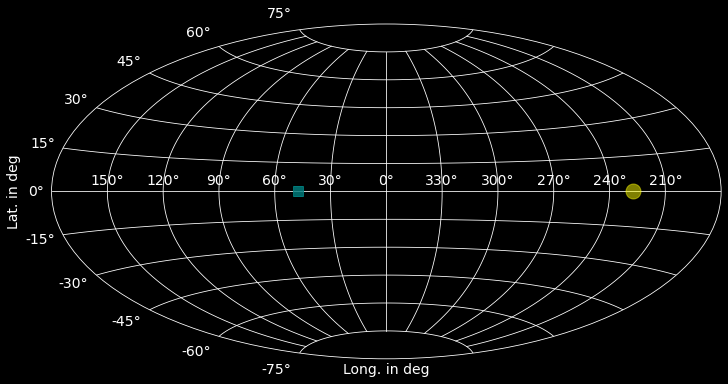

In [20]:
# Now we plot the sky plot with the Sun and the corresponding Opposition direction

# Use a dark background
plt.style.use('dark_background')

# Set a figure
plt.figure(figsize=(12, 8))

# Apply the aitoff projection and activate the grid
plt.subplot(projection="aitoff")
plt.grid(True)

# Set long. / lat. labels
plt.xlabel('Long. in deg')
plt.ylabel('Lat. in deg')

# Replace the standard x ticks (longitude) with the ecliptic coordinates
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])

# Add the Sun
plt.plot(sun_ecl_long_4plot,
         sun_ecl_lat,
         color="yellow",
         marker="o",
         markersize=15,
         alpha=0.5)

# Add the Opposition point
plt.plot(sun_opp_ecl_long_4plot,
         sun_opp_ecl_lat,
         color="teal",
         marker="s",
         markersize=10,
         alpha=0.8)

plt.show()

In [21]:
# We compute now the NEO's coordiantes in a similar way using the dataframe and the apply function.
neo_df.loc[:, "earth2neo_position_vec_AU"] = \
    neo_df["neo2earth_position_vec_AU"].apply(lambda x: -1.0 * np.array(x))

neo_df.loc[:, "earth2neo_recrad"] = \
    neo_df["earth2neo_position_vec_AU"].apply(lambda x: spiceypy.recrad(x))

neo_df.loc[:, "earth2neo_dist_AU"] = \
    neo_df["earth2neo_recrad"].apply(lambda x: x[0])

neo_df.loc[:, "earth2neo_eclip_long"] = \
    neo_df["earth2neo_recrad"].apply(lambda x: x[1])

neo_df.loc[:, "earth2neo_eclip_lat"] = \
    neo_df["earth2neo_recrad"].apply(lambda x: x[2])

# Before we plot the data, we need to convert the longitude data into a
# matplotlib compatible format. We computed longitude values between 0 and
# 2*pi (360 degrees). matplotlib expects values between -pi and +pi. Further,
# sky maps count from 0 degrees longitude to the left. Thus we need also to
# invert the longitude values
neo_df.loc[:, "earth2neo_eclip_long_4plot_ecl"] = \
    neo_df["earth2neo_eclip_long"].apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi else -1*x)

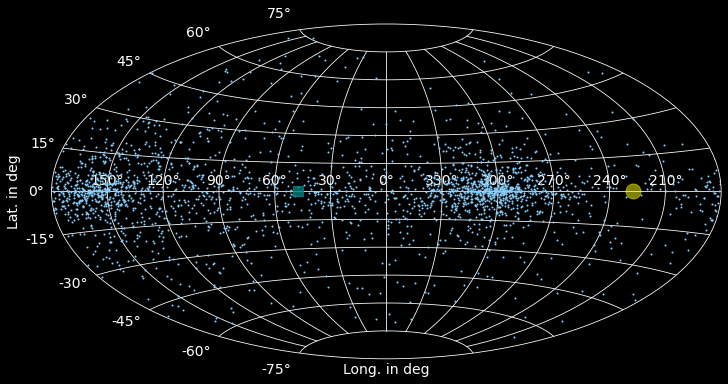

In [22]:
# Example from video:
# neo_sub_df = neo_df.loc[(neo_df["app_mag"] < 24) \
#                        & (neo_df["AbsMag_"] > 20) \
#                        & (neo_df["earth2neo_dist_AU"] < 0.25)].copy()
neo_sub_df = neo_df.loc[(neo_df["app_mag"] > 25) \
                        & (neo_df["AbsMag_"] > 22) \
                        & (neo_df["earth2neo_dist_AU"] < 1)].copy()

# Use a dark background
plt.style.use('dark_background')

# Set a figure
plt.figure(figsize=(12, 8))

# Apply the aitoff projection and activate the grid
plt.subplot(projection="aitoff")
plt.grid(True)

# Set long. / lat. labels
plt.xlabel('Long. in deg')
plt.ylabel('Lat. in deg')

plt.plot(neo_sub_df["earth2neo_eclip_long_4plot_ecl"], \
         neo_sub_df["earth2neo_eclip_lat"], \
         marker='.', linestyle='None', markersize=2, alpha=1, color="lightskyblue")

# Replace the standard x ticks (longitude) with the ecliptic coordinates
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])

# Add the Sun
plt.plot(sun_ecl_long_4plot,
         sun_ecl_lat,
         color="yellow",
         marker="o",
         markersize=15,
         alpha=0.5)

# Add the Opposition point
plt.plot(sun_opp_ecl_long_4plot,
         sun_opp_ecl_lat,
         color="teal",
         marker="s",
         markersize=10,
         alpha=0.8)

plt.show()

# Interactive Tool

Today we will learn how to create an interactive sky map! Using [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html) we can add sliders, date-time pickers, and / or drop-down menus to customize our small dashboard in this Jupyter-Notebook. That way, we can adjust parameters of interest more easily!

In [23]:
# To enable interactivitiy, we need ipywidgets
import ipywidgets

In [24]:
# Using the SPICE functionvsep, we add a new row: the angular distance between the NEO(s) and the
# Sun.
#
# Background: NEO surveys, or "night time" telescopes (there are Sun-telescopes, so that's why I
# describe it so strangely), could theoretically operate during dusk and dawn. However, depending
# on the optics and camera system, even a bright sky could damage the instrument.
# Since we do no model a horizon, we take a angular distance between NEOs and the Sun as a rough
# "protection estimate"
neo_df.loc[:, "ang_dist_neo2sun_deg"] = \
    neo_df["earth2neo_position_vec_AU"].apply(lambda x:
                                              np.degrees(spiceypy.vsep(x, earth2sun_position_vec)))

In [25]:
# First we set up some nice interactive widgets

# This cell contains miscellaneous widget elements that are being used in our interactive plotting
# routine

# A date picker to e.g., compute the positions of the NEOs and the position of the Sun. However,
# here, it is disabled. Adding this functionality would be a nice "homework" for you!
date_picker_widget= ipywidgets.DatePicker(
    description='Date',
    diabled=True
)

# We add also a drop-down menu to select the NEO class
neo_class_widget = ipywidgets.Dropdown(
    options=['Amor', 'Apollo', 'Aten', 'Atira', 'Other', 'All'],
    description="NEO Class"
)

# 2 selection range slider to add filtering options for the apparent and absolute magnitude
app_mag_widget = ipywidgets.SelectionRangeSlider(
    options=range(5, 31),
    index=[0, 10],
    description='App. Mag'
)

abs_mag_widget = ipywidgets.SelectionRangeSlider(
    options=range(9, 35),
    index=[0, 10],
    description='Abs. Mag'
)

# Angular distance between Sun and NEO(s)
ang_dist_widget = ipywidgets.IntSlider(
    value=0,
    min=0,
    max=60,
    step=1,
    description="Sun-Dist",
)

In [26]:
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=12)

# Set a function for the (interactive) plots
def plot_sky_map(date, neo_class, app_mag, abs_mag, ang_dist):
    
    # Set a figure
    plt.figure(figsize=(12, 8))

    # Apply the aitoff projection and activate the grid
    plt.subplot(projection="aitoff")
    plt.grid(True)

    # Set long. / lat. labels
    plt.xlabel('Long. in deg')
    plt.ylabel('Lat. in deg')

    # NEO Class filtering
    if neo_class == "All":
        _filtered_neo_df = neo_df.copy()
    else:
        _filtered_neo_df = neo_df.loc[neo_df["NEOClass"]==neo_class]

    # App. and Abs. Magnitude filtering
    _filtered_neo_df = _filtered_neo_df.loc[(_filtered_neo_df["app_mag"] >= app_mag[0])
                                            & (_filtered_neo_df["app_mag"] <= app_mag[1])]

    _filtered_neo_df = _filtered_neo_df.loc[(_filtered_neo_df["AbsMag_"] >= abs_mag[0])
                                            & (_filtered_neo_df["AbsMag_"] <= abs_mag[1])]
    
    # Angular distance filtering
    _filtered_neo_df = _filtered_neo_df.loc[_filtered_neo_df["ang_dist_neo2sun_deg"] > ang_dist]
    
    # Plotting the NEOs
    plt.plot(_filtered_neo_df["earth2neo_eclip_long_4plot_ecl"], \
             _filtered_neo_df["earth2neo_eclip_lat"], \
             marker='.',
             linestyle='None',
             markersize=2,
             alpha=1,
             color="lightskyblue")

    # Replace the standard x ticks (longitude) with the ecliptic coordinates
    plt.xticks(ticks=np.radians([-150,-120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
               labels=['150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', 
                       '210°'])

    # Add the Sun
    plt.plot(sun_ecl_long_4plot,
             sun_ecl_lat,
             color="yellow",
             marker="o",
             markersize=15,
             alpha=0.5)

    # Add the Opposition point
    plt.plot(sun_opp_ecl_long_4plot,
             sun_opp_ecl_lat,
             color="teal",
             marker="s",
             markersize=10,
             alpha=0.8)
    
    # Plot the total number of visible NEOs
    plt.title(f"#NEOs: {len(_filtered_neo_df)}", fontsize=12)
    
    plt.show()
    
# Create an interactive session!
ipywidgets.interactive(plot_sky_map,
                       date=date_picker_widget,
                       neo_class=neo_class_widget,
                       app_mag=app_mag_widget,
                       abs_mag=abs_mag_widget,
                       ang_dist=ang_dist_widget)

interactive(children=(DatePicker(value=None, description='Date'), Dropdown(description='NEO Class', options=('…